In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(2018)

## Read Data

In [2]:
data = pd.read_csv("Audi_Desc_Count.csv")
data = data[data['body'].notna()] # remove nulls
data = data.reset_index() #reset index
data = data.drop(columns=['index'])
data.head(2)

,author_id,author_name,body,downs,id,isPost,parent_id,post_id,time,title,ups,url,descendant_count
0,t2_59jqzaxc,necro-audiophile,I would definitely do a chrome delete since yo...,0,t1_fcmr565,False,t3_ehy1eh,t3_ehy1eh,1.577788e+09,Looking to make additional mods - ideas?,6,NaN,0
1,t2_4a6kttnr,throwaway72592309,You could do a front splitter or a rear diffuser,0,t1_fcn5hhn,False,t3_ehy1eh,t3_ehy1eh,1.577804e+09,Looking to make additional mods - ideas?,3,NaN,0


## Preprocessing (Data Cleaning)

In [3]:
df = data.copy()

#change any int/float to str
df['body'] = df['body'].apply(str)

# Convert the reviews to lowercase
df['body'] = df['body'].map(lambda x: x.lower())

In [4]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk import PorterStemmer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nimee\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
#Stemming & Lemmatizing
stemmer = PorterStemmer()
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

df['comments_processed'] = pd.DataFrame(df['body'].map(preprocess))

In [6]:
tokens = df['comments_processed']

## Word2Vec

In [7]:
from gensim.models import Word2Vec

In [8]:
#Train Word2Vec model for word embeddings
w2v_model = Word2Vec(tokens,
                     min_count=500,
                     window=10,
                     size=250,
                     alpha=0.03, 
                     min_alpha=0.0007,
                     workers = 4,
                     seed = 42)

In [9]:
Z = w2v_model.wv.syn0;

C:\Users\nimee\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


## Visualize Word2Vec using TSNE

In [10]:
from sklearn.manifold import TSNE

In [11]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=50, n_components=2, init='pca', n_iter=2000, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(15, 13)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

C:\Users\nimee\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


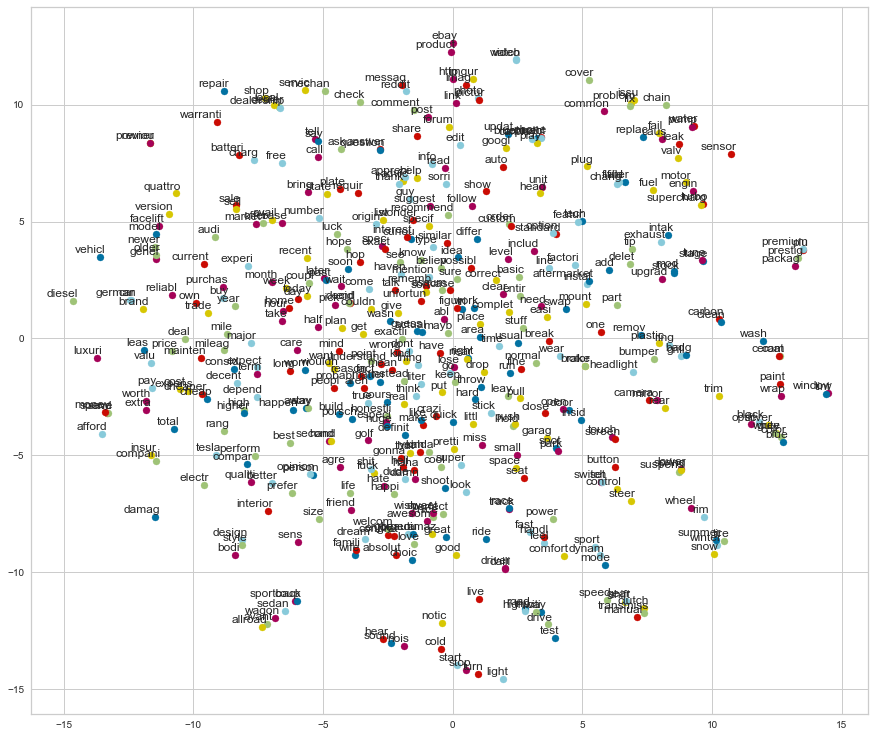

In [181]:
tsne_plot(w2v_model)

## Clustering using KMeansClusterer

In [12]:
from nltk.cluster import KMeansClusterer
from sklearn.manifold import TSNE

In [14]:
num_clusters = 35
kclusterer = KMeansClusterer(num_clusters, distance=nltk.cluster.util.cosine_distance, repeats=25)
assigned_clusters = kclusterer.cluster(Z, assign_clusters=True)
print(assigned_clusters) 

[16, 18, 7, 24, 14, 6, 4, 2, 6, 7, 27, 20, 30, 1, 7, 5, 27, 12, 22, 2, 23, 19, 14, 4, 23, 23, 2, 19, 21, 16, 7, 20, 4, 21, 8, 9, 7, 12, 14, 12, 33, 2, 5, 22, 29, 16, 34, 8, 33, 23, 8, 19, 0, 1, 14, 14, 9, 31, 33, 8, 2, 8, 0, 18, 17, 7, 33, 22, 31, 13, 23, 34, 19, 21, 27, 28, 8, 31, 4, 13, 4, 33, 22, 33, 29, 9, 8, 34, 1, 33, 13, 24, 25, 15, 3, 15, 9, 8, 14, 6, 24, 10, 4, 20, 0, 1, 2, 9, 31, 7, 10, 24, 25, 7, 19, 30, 20, 2, 14, 0, 33, 31, 21, 7, 1, 20, 2, 19, 11, 4, 24, 1, 22, 4, 2, 4, 4, 30, 2, 6, 33, 15, 26, 12, 19, 24, 8, 1, 16, 2, 9, 29, 29, 30, 32, 7, 18, 27, 0, 12, 2, 4, 17, 17, 20, 1, 5, 5, 7, 4, 2, 25, 29, 14, 12, 12, 14, 29, 28, 13, 6, 24, 27, 23, 21, 6, 11, 2, 34, 30, 23, 17, 29, 30, 19, 14, 14, 31, 19, 5, 33, 31, 7, 23, 17, 14, 0, 1, 24, 32, 25, 23, 20, 4, 19, 25, 15, 19, 18, 17, 15, 22, 1, 1, 27, 1, 0, 5, 0, 9, 29, 8, 33, 21, 16, 34, 23, 11, 31, 6, 28, 6, 1, 3, 15, 26, 1, 12, 32, 24, 25, 18, 12, 2, 1, 15, 21, 1, 2, 18, 15, 27, 18, 34, 8, 19, 8, 32, 28, 8, 17, 12, 15, 21, 21, 

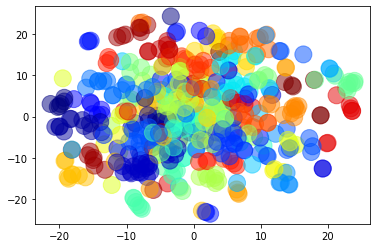

In [17]:
tsnemodel = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)

Y = tsnemodel.fit_transform(Z)

plt.scatter(Y[:, 0], Y[:, 1], c=assigned_clusters, s=290,alpha=.5,cmap='jet')
plt.show()

## Clustering using KMeans

In [18]:
from sklearn.cluster import KMeans;
from sklearn.neighbors import KDTree;
from itertools import cycle;
from wordcloud import WordCloud, ImageColorGenerator

In [19]:
def clustering_on_wordvecs(word_vectors, num_clusters):
    # Initalize a k-means object and use it to extract centroids
    kmeans_clustering = KMeans(n_clusters = num_clusters, init='k-means++');
    idx = kmeans_clustering.fit_predict(word_vectors);
    
    return kmeans_clustering.cluster_centers_, idx, kmeans_clustering.labels_;

In [20]:
centers, clusters, labels = clustering_on_wordvecs(Z, 35);
centroid_map = dict(zip(w2v_model.wv.index2word, clusters));

## Optimum number of Clusters

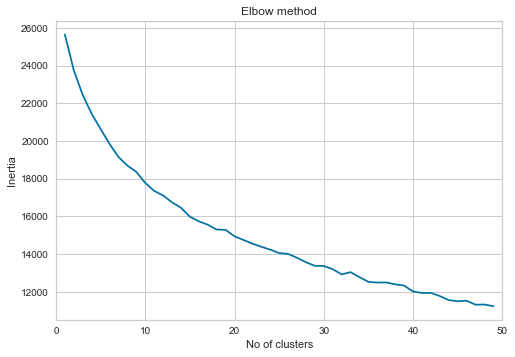

In [231]:
SSE =[]
for clusters in range(1, 50):
    kmeans = KMeans(n_clusters = clusters).fit(Z)
    kmeans.fit(Z)
    SSE.append(kmeans.inertia_)
import matplotlib.pyplot as plt
plt.plot(range(1, 50), SSE)
plt.xlim(0,50)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Inertia')
plt.show()

## Get top 20 words from each cluster

In [21]:
def get_top_words(index2word, k, centers, wordvecs):
    tree = KDTree(wordvecs);

    #Closest points for each Cluster center is used to query the closest 20 points to it.
    closest_points = [tree.query(np.reshape(x, (1, -1)), k=k) for x in centers];
    closest_words_idxs = [x[1] for x in closest_points];

    #Word Index is queried for each position in the above array, and added to a Dictionary.
    closest_words = {};
    for i in range(0, len(closest_words_idxs)):
        closest_words['Cluster #' + str(i+1).zfill(2)] = [index2word[j] for j in closest_words_idxs[i][0]]

    #A DataFrame is generated from the dictionary.
    df = pd.DataFrame(closest_words);
    df.index = df.index+1

    return df;

In [22]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [23]:
top_words = get_top_words(w2v_model.wv.index2word, 20, centers, Z);
top_words

,Cluster #01,Cluster #02,Cluster #03,Cluster #04,Cluster #05,Cluster #06,Cluster #07,Cluster #08,Cluster #09,Cluster #10,Cluster #11,Cluster #12,Cluster #13,Cluster #14,Cluster #15,Cluster #16,Cluster #17,Cluster #18,Cluster #19,Cluster #20,Cluster #21,Cluster #22,Cluster #23,Cluster #24,Cluster #25,Cluster #26,Cluster #27,Cluster #28,Cluster #29,Cluster #30,Cluster #31,Cluster #32,Cluster #33,Cluster #34,Cluster #35
1,matter,unfortun,spring,transmiss,motor,high,sort,ring,unfortun,citi,older,coup,cours,bluetooth,sweet,tune,prestig,close,caus,add,cheaper,summer,shift,coat,coupl,switch,entir,save,buy,reddit,link,sport,expect,push,grey
2,exactli,assum,lower,clutch,fail,higher,interest,one,throw,drive,newer,golf,huge,play,damn,mod,packag,insid,fail,curiou,expens,winter,gear,ceram,later,set,mount,spend,pay,messag,imag,dynam,consid,fine,silver
3,cours,call,suspens,shift,valv,especi,curiou,grill,near,highway,gener,prefer,especi,connect,nice,stock,plu,garag,fix,includ,cost,rim,speed,paint,day,button,remov,worth,purchas,comment,edit,comfort,cours,normal,white
4,honestli,exactli,ride,gear,engin,cours,wonder,ebay,go,road,true,sedan,quick,carplay,perfect,stage,premium,leav,break,entir,total,tire,manual,wash,today,control,requir,money,free,follow,photo,seat,decent,throw,color
5,that,exact,drop,manual,leak,expect,hop,entir,sort,trip,similar,wish,crazi,googl,awesom,exhaust,standard,spot,fine,basic,probabl,snow,push,clear,half,touch,plastic,extra,trade,imag,show,miss,especi,stop,blue
6,wrong,case,littl,motor,run,depend,know,plastic,put,wife,cours,sportback,definit,phone,hell,delet,option,stick,mechan,believ,cheap,wheel,mode,wrap,past,push,bumper,afford,give,delet,pictur,better,term,notic,black
7,kind,mention,add,speed,filter,perform,mention,look,mayb,cours,believ,avant,honestli,unit,welcom,intak,optic,right,case,spec,aren,size,fast,correct,go,stick,easi,pay,deal,post,follow,feel,reason,away,wrap
8,think,give,put,normal,pump,decent,unfortun,swap,crazi,especi,version,allroad,like,updat,wish,upgrad,includ,place,follow,sure,compani,perfect,switch,place,decid,insid,correct,wouldn,expect,link,type,ride,matter,run,gorgeou
9,guess,talk,cours,throw,fuel,huge,suggest,correct,exactli,go,base,wagon,littl,show,that,supercharg,trim,near,possibl,standard,assum,drop,stick,clean,couldn,hold,complet,want,care,sorri,post,interior,honestli,pull,look
10,mean,interest,sweet,wear,turbo,basic,exactli,style,liter,fast,interest,instead,put,case,beauti,add,pick,push,problem,edit,case,get,auto,area,end,play,stick,reason,year,edit,sorri,handl,older,start,exact


## Word Cloud of each cluster

In [24]:
def display_cloud(cluster_num, cmap):
    wc = WordCloud(background_color="black", max_words=2000, max_font_size=80, colormap=cmap);
    wordcloud = wc.generate(' '.join([word for word in top_words['Cluster #' + str(cluster_num).zfill(2)]]))

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig('cluster_' + str(cluster_num), bbox_inches='tight')

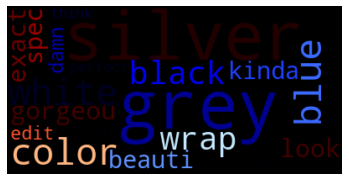

In [25]:
cmaps = cycle([
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'hsv',
            'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar'])

for i in range(35):
    col = next(cmaps)
    display_cloud(i+1, col)

## Silhouette score

In [28]:
from sklearn import cluster
from sklearn import metrics
 
silhouette_score = metrics.silhouette_score(Z, clusters, metric='euclidean')
 
print ("Silhouette_score: ")
print (silhouette_score)

Silhouette_score: 
0.054021053


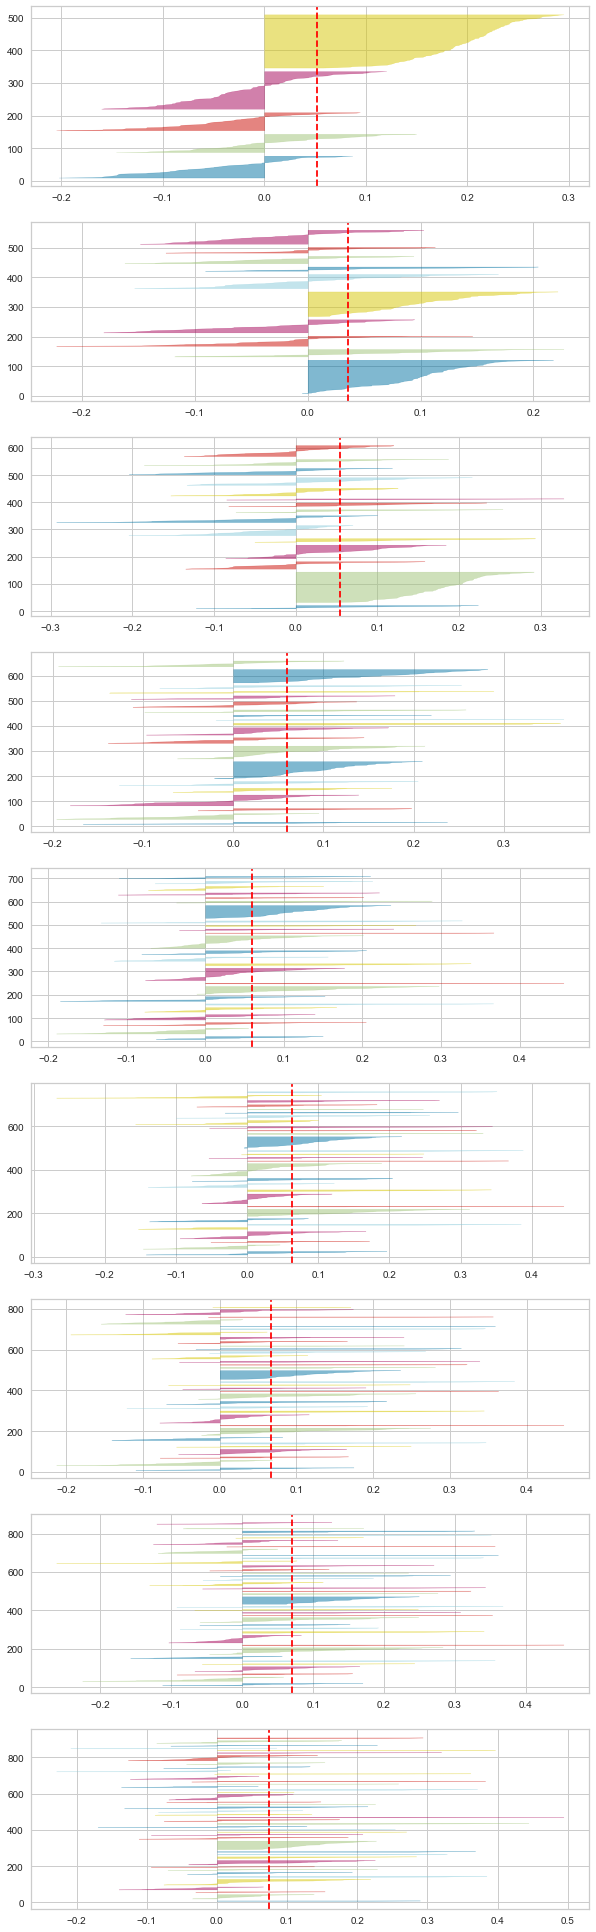

In [27]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(9,1, figsize=(10,35), squeeze = False)
for i in [5,10,15,20,25,30,35,40,45]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 5)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(Z)